In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

from tqdm import tqdm

/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda:1' #torch.device(torch.cuda.get_device_name(1))

In [4]:
MODEL_TYPE = 'LRAE'
MODEL_TYPE = 'VAE'
# model_name = 'MNIST__VAE_128__50__10ktrain'
model_name = 'Test_sigmoid_VAE_128__50'
# model_name = 'Test_ReLU_path_LRAE_128__50'




GOOD_MODEL_TYPE = ['VAE', 'AE', 'LRAE']
assert MODEL_TYPE in GOOD_MODEL_TYPE, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"

# Upload model

In [5]:
from models.R1AE import ConvLRAE, ConvVAE, ConvAE


In [6]:
# PARAMETERS
IN_FEATURES = 256*2*2
OUT_FEATURES = 128
N_BINS = 20
GRID = torch.arange(1,N_BINS+1).to(device)/N_BINS

# nonlinearity = 

DROPOUT = 0.0
TEMP = 0.5
SAMPLING = 'gumbell'



In [7]:
if MODEL_TYPE == 'LRAE':
     model = ConvLRAE(IN_FEATURES, OUT_FEATURES, N_BINS, GRID, dropout=DROPOUT, nonlinearity=nn.ReLU(),
                sampling=SAMPLING, temperature=TEMP,).to(device)
elif MODEL_TYPE == 'VAE':
    model = ConvVAE(IN_FEATURES, OUT_FEATURES, nonlinearity=nn.ReLU()).to(device)
elif MODEL_TYPE == 'AE':
    model = ConvAE(IN_FEATURES, OUT_FEATURES, nonlinearity=nn.ReLU()).to(device)
else:
    assert False, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"
    
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
print(f"{MODEL_TYPE} was inisialized")

VAE was inisialized


In [8]:
# Upload the model
model_dir = 'saved_models'
model_dir = ''
# model_name = 'MNIST__VAE_128__50__10ktrain'

model_path = os.path.join(model_dir, model_name + '.pth')

In [9]:
## Loading
# PATH = "MNIST__gumbell__entropy__200"
# PATH = "MNIST__VAE__8__25"
PATH = model_path

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loss_list_train = checkpoint['loss_list_train']
loss_list_test = checkpoint['loss_list_test']

# Dataset

In [10]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [11]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 60000
TEST_SIZE = 5000
BATCH_SIZE = 32
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=10)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=10)

#full dataset train
FULL_TRAIN_SIZE = 60000
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 10000
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

torch.Size([60000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


# Evaluation

In [12]:
from models.evaluation import inf_by_layers, check_reconstruction, gen_idx_for_batches, display_datasets
from models.evaluation import gen_gm_dataset, update_FID_class, ManualFID, prepare_to_FID
from torchmetrics.image.fid import FrechetInceptionDistance as tm_FrechetInceptionDistance
from torcheval.metrics import FrechetInceptionDistance

from sklearn.mixture import GaussianMixture

In [13]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))  
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_test.to(device))

### Loss function

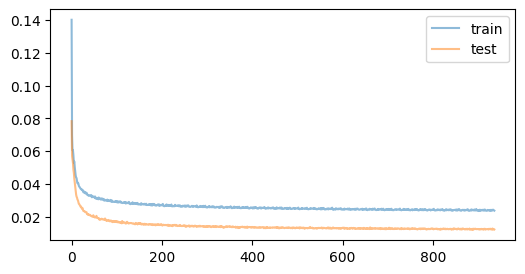

In [14]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig(f'MNIST_{model_name}_loss.png')
plt.show()

## Reconstruction

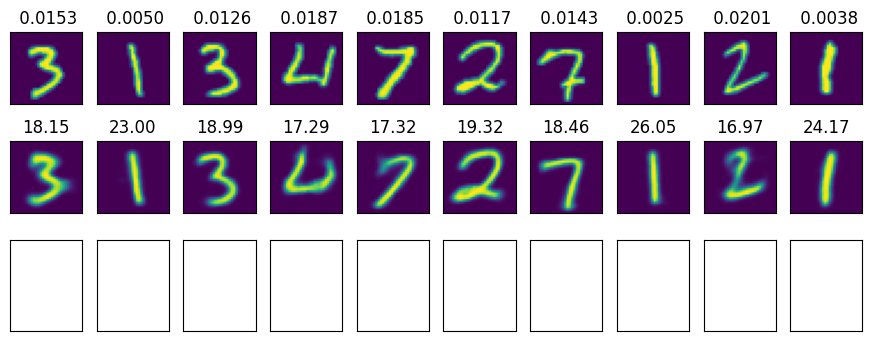

In [15]:
# Check reconstruction
check_reconstruction(model, X_full_test.to(device))
# plt.show()

In [16]:
## Calculate reconstruction
# MSE
mse_train = torch.nn.MSELoss()(decoded_2d1.cpu().detach(), X_full_train.cpu().detach())
mse_test = torch.nn.MSELoss()(decoded_2d2.cpu().detach(), X_full_test.cpu().detach())
print(f"MSE: {mse_test.item():.4f}({mse_train.item():.4f})")

# PSNR
psnr_train = 10*torch.log10(1 / (mse_train + 1e-20))
psnr_test = 10*torch.log10(1 / (mse_test + 1e-20))

print(f"PSNR: {psnr_test.item():.2f}({psnr_train.item():.2f})")

MSE: 0.0127(0.0124)
PSNR: 18.97(19.08)


# Generation

In [17]:

device_fid = 'cuda:0'
model = model.to(device)
EMB_SIZE = 128

In [18]:
# Setup generating

dataset_list = []
dataset_names = []
ground_truth = X_full_train.detach().cpu()
# N_samples = ground_truth.shape[0]
N_samples = 50000
print("N_samples =", N_samples)

N_samples = 50000


In [19]:
# Generating samples Truth
dataset_truth = ground_truth # full dataset
dataset_list +=[dataset_truth]
dataset_names += ['Truth']
print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])

Truth samples =  60000


In [20]:
# Generating samples from autoencoders
model_dataset = gen_gm_dataset(model, encoded_out_dim1, n_components=1, total_size=50000, batch_size=1024*5, C_H_W = [256, 2, 2], max_iter=500)
dataset_list +=[model_dataset]
dataset_names += [MODEL_TYPE + '_gm1']

print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])


5120 x 9 + 3920 == 50000(51200)


100%|██████████| 10/10 [00:00<00:00, 14.72it/s]


VAE_gm1 samples =  50000


In [21]:
# Generating samples from autoencoders
model_dataset = gen_gm_dataset(model, encoded_out_dim1, n_components=4, total_size=50000, batch_size=1024*5, C_H_W = [256, 2, 2], max_iter=500)
dataset_list +=[model_dataset]
dataset_names += [MODEL_TYPE + '_gm4']

print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])

5120 x 9 + 3920 == 50000(51200)


100%|██████████| 10/10 [00:00<00:00, 12.31it/s]


VAE_gm4 samples =  50000


#### display 

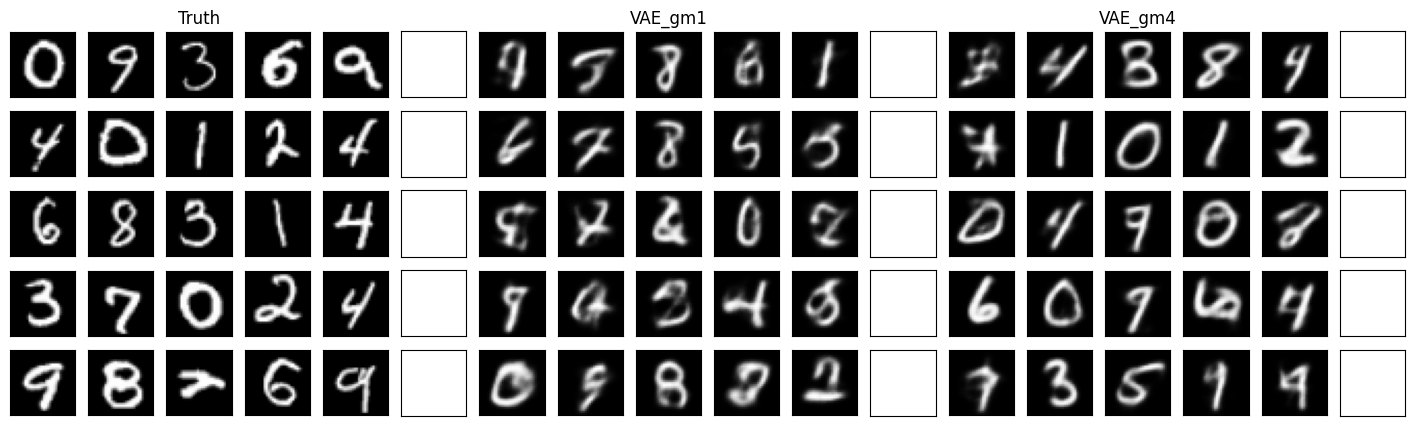

In [22]:
display_datasets(dataset_list, dataset_names)

#### FID calculation

In [23]:


def prepare_to_FID(dataset):

    B_, C_, H_, W_ = dataset.shape
    

    preprocess = transforms.Compose([transforms.Resize(299)
                                    #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ,])

    imgs = dataset
    imgs = imgs.view(B_, C_, -1)
    imgs = imgs - imgs.min(-1, keepdims=True)[0]
    imgs = imgs/imgs.max(-1, keepdims=True)[0]
    imgs = imgs.reshape(B_, C_, H_, W_)

    C_ = 3 
    imgs = preprocess(imgs.expand(B_, C_, H_, W_))

    return imgs
    
    
    

In [26]:
imgs_real, imgs_fake, imgs_fake_gm4 = prepare_to_FID(dataset_list[0]), prepare_to_FID(dataset_list[1]), prepare_to_FID(dataset_list[2])

In [231]:
## FID 1
# fake
fid = FrechetInceptionDistance(device=device_fid)
torch.cuda.empty_cache()
fid.reset()
torch.cuda.empty_cache()
update_FID_class(fid, imgs_real, True, batch_size=512)
# print(fid.compute().detach().cpu())
update_FID_class(fid, imgs_fake, False, batch_size=512)
auto_fid = fid.compute().detach().cpu()
print("fake:", auto_fid, '\n')


# fake gm4
fid = FrechetInceptionDistance(device=device_fid)
torch.cuda.empty_cache()
fid.reset()
torch.cuda.empty_cache()
update_FID_class(fid, imgs_real, True, batch_size=512)
# print(fid.compute().detach().cpu())
update_FID_class(fid, imgs_fake, False, batch_size=512)
auto_fid_gm4 = fid.compute().detach().cpu()
print("fake gm4:", auto_fid_gm4)

512 x 1 + 488 == 1000(1024)


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


512 x 1 + 488 == 1000(1024)


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


tensor(59.8388)

In [230]:
# FID 2
torch.cuda.empty_cache()
m_fid = ManualFID(device=device)
m_fid.update_full(imgs_real, True, batch_size=512)
m_fid.update_full(imgs_fake, False, batch_size=512)
m_fid_value = m_fid.compute()
print("fake:", m_fid_value, '\n')

m_fid.clear_part(is_real=False)
m_fid.update_full(imgs_fake_gm4, False, batch_size=512)
m_fid_value_gm4 = m_fid.compute()
print("fake gm4:", m_fid_value_gm4)

Using cache found in /home/s.gostilovich/.cache/torch/hub/pytorch_vision_v0.10.0
/home/s.gostilovich/.venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s.gostilovich/.venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512 x 1 + 488 == 1000(1024)


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Real is done!
512 x 1 + 488 == 1000(1024)


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Fake is done!


tensor(59.8423)

In [28]:

print(f"FID gm1: {auto_fid.item() :.2f} ({m_fid_value}); FID gm4: {auto_fid.item() :.2f} ({m_fid_value_gm4});")
print(f"FID gm1: {auto_fid.item() :.2f}; FID gm4: {auto_fid.item() :.2f};")
# print(f"FID: {auto_fid.item() :.2f} | {m_fid_value.item() :.2f} | {auto_tm_fid.item() :.2f}")

FID: 24.88 | 25.28 | 42.85


In [ ]:
# # FID 3
# tm_fid = tm_FrechetInceptionDistance(normalize=True, reset_real_features=True)
# torch.cuda.empty_cache()
# tm_fid.to(device_fid)
# tm_fid.reset()
# torch.cuda.empty_cache()
# update_FID_class(tm_fid, imgs_real[:1000], True, batch_size=512)
# # print(fid.compute().detach().cpu())
# update_FID_class(tm_fid, imgs_fake[:1000], False, batch_size=512)
# auto_tm_fid = tm_fid.compute().detach().cpu()
# auto_tm_fid


# Visualization (PCA and tNSE)

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

enc_pca = pca.fit_transform(encoded_out_dim1.cpu().detach().numpy())
enc_pca1 = pca.fit_transform(encoded_out_dim2.cpu().detach().numpy())

enc_tsne = tsne.fit_transform(encoded_out_dim1.cpu().detach().numpy())
enc_tsne1 = tsne.fit_transform(encoded_out_dim2.cpu().detach().numpy())

# enc_pca = enc.detach().numpy()
# enc_pca1 = enc1.detach().numpy()

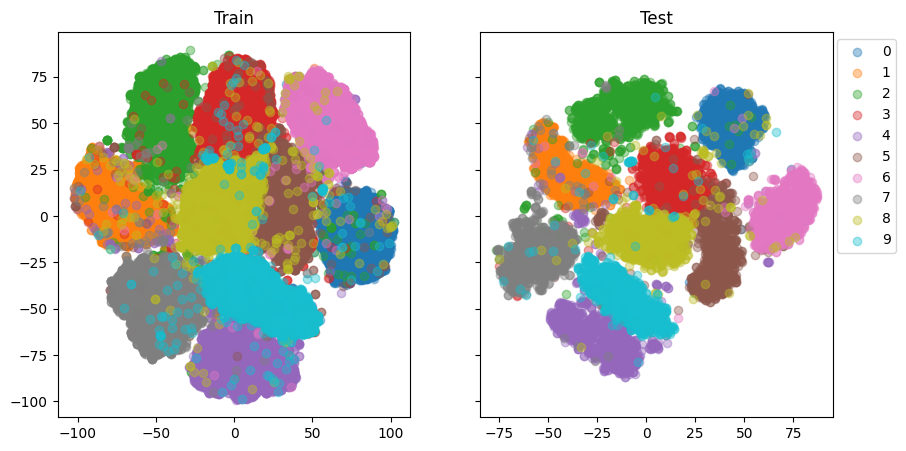

In [48]:
# TSNE
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_tsne[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.4)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_tsne1[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.4)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

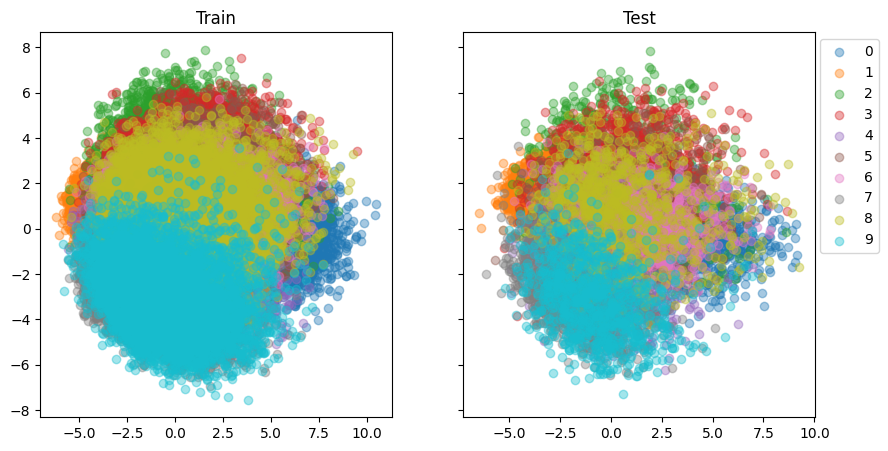

In [50]:
# PCA
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_pca[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.4)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_pca1[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.4)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

In [33]:
EMB_SIZE = 8

In [91]:
EMB_SIZE = 128
PCA_SIZE = 4
pca = PCA(n_components=PCA_SIZE)
pca.fit(encoded_out_dim1.cpu().detach().numpy())
pca.transform(torch.randn(1,EMB_SIZE)*torch.std(encoded_out_dim1, dim=0).cpu()
               + torch.mean(encoded_out_dim1, dim=0).cpu())

array([[ 1.3379141 ,  0.68616609, -1.60630445,  0.44231961]])

In [92]:
enc_pca = pca.transform(encoded_out_dim1.cpu().detach().numpy())
mean_enc_pca = np.mean(enc_pca, axis=0)
std_enc_pca = np.std(enc_pca, axis=0)
print(mean_enc_pca)
print(std_enc_pca)

[ 8.3830355e-07 -4.7270061e-07  3.4983555e-07  2.3694882e-07]
[2.9085057 2.6375263 2.5572107 2.49722  ]


In [93]:
rand = np.random.randn(B, PCA_SIZE)*std_enc_pca + mean_enc_pca
rand = pca.inverse_transform(rand)

rand = torch.as_tensor(rand, dtype=torch.float32)

C, H, W = 128, 4, 4
decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
decoded_2d_small = decoded_1d.view(B, C, H, W)
decoded_2d = model.up(decoded_2d_small)

model_dataset = decoded_2d.detach().cpu()
# model_dataset = model_dataset*(model_dataset > 0)
dataset_list +=[model_dataset]
dataset_names += ['VAE_pca']

In [59]:
rand.shape

(60000, 128)

## Interpolation

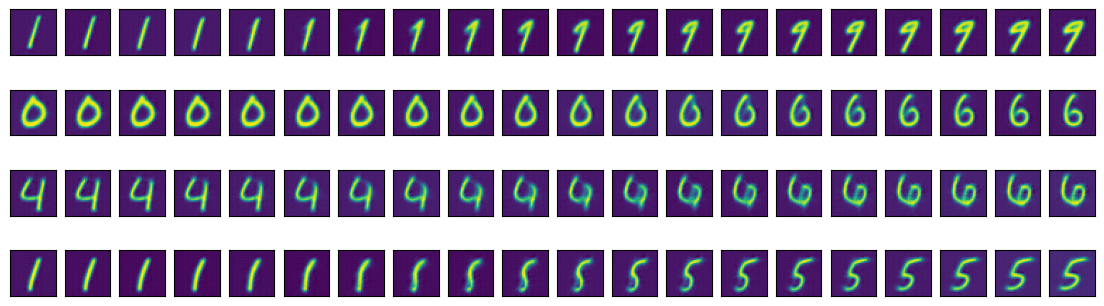

In [129]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(4,20, figsize=(14,4))
for i in range(0,20):
    with torch.no_grad():
        model.eval()
            
        for j in range(4):
            # encode two numbers
            # NUMBER 1
            IDX_1 = j+2
            x_down1 = model.down(X_full_test[IDX_1].unsqueeze(0).to(device))
            B, C, H, W = x_down1.shape
            x_flat1 = x_down1.view(B,C*H*W)
            encoded_inter_dim1 =                    model.low_rank.encoder(x_flat1)
            encoded_out_dim1, factors_probability1 = model.low_rank.low_rank_pants(encoded_inter_dim1)

            # NUMBER 2
            IDX_2 = j+20
            x_down2 = model.down(X_full_test[IDX_2].unsqueeze(0).to(device))
            B, C, H, W = x_down2.shape
            x_flat2 = x_down2.view(B,C*H*W)
            encoded_inter_dim2 =                    model.low_rank.encoder(x_flat2)
            encoded_out_dim2, factors_probability2 = model.low_rank.low_rank_pants(encoded_inter_dim2)

            # decode and plot
            new_encoded = (1-i/axs.shape[-1])*encoded_out_dim1 + (i/axs.shape[-1])*encoded_out_dim2
            decoded_inter_dim =  model.low_rank.intermediate_decoder(new_encoded)
            decoded_1d = model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
plt.show()

# Classification test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### from factors_probability 

In [ ]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    
# for j in range(factors_probability.shape[1]):
#     plt.plot(factors_probability[0, j, :].detach().cpu())

In [ ]:
X_class_train, X_class_test = prob_latent_train, prob_latent_test

In [ ]:
# Low rank
n_components = 20
pca_ = PCA(n_components=prob_latent_train.shape[-1])
pca_.fit(prob_latent_train)
plt.plot(pca_.explained_variance_)
plt.vlines([n_components], ymin = plt.gca().get_ylim()[0], ymax = plt.gca().get_ylim()[1], colors=['r'], linestyles=['--'])

pca_f = PCA(n_components=prob_latent_train.shape[-1]).fit(prob_latent_train)
X_class_train = pca_f.transform(prob_latent_train)
X_class_test= pca_f.transform(prob_latent_test)


#### from encoded_out_dim

In [ ]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    # prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_train = encoded_out_dim.detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_test = encoded_out_dim.detach().cpu()
    
   


In [ ]:
X_class_train, X_class_test = encoded_out_dim_train, encoded_out_dim_test

In [ ]:
(encoded_out_dim_train != X_class_train).sum()

#### Classification  

In [ ]:
X_train, y_train = X_class_train, targets
X_test, y_test= X_class_test, targets_test

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


In [ ]:
plt.figure(figsize=[15, 6])
nx, ny = 2, 5
for i in range(10):
    plt.subplot(nx, ny, i+1)
    plt.bar(np.arange(clf.coef_.shape[1])+1, clf.coef_[i, :])
    if i % ny != 0:
        plt.gca().set_yticks([])
        
    # plt.gca().set_yticks([-10, 0, 10])
    plt.gca().set_ylim([-40, 40])
    plt.gca().set_xticks([])
    # plt.grid()
    plt.title(str(i))

In [ ]:
# for i in range(10):
#     plt.scatter(clf.coef_[i, 0], clf.coef_[i, 1],)

In [ ]:
print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

In [ ]:
# plt.figure(figsize=[16, 4])

# # plt.subplot(1, 3, 1)
# plt.figure(figsize=[8, 7])
# cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_, normalize='all')
# disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 3), display_labels=clf.classes_)
# disp.plot(ax = plt.gca())
# plt.title('Train')
# plt.show()



# plt.subplot(1, 3, 2)
plt.figure(figsize=[8, 7])
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=clf.classes_)
disp.plot(ax = plt.gca())
plt.title('Test')

# Other

#### Dist grapths

In [80]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, X_full_test.to(device))
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))
    


Text(0.5, 0.98, 'Train')

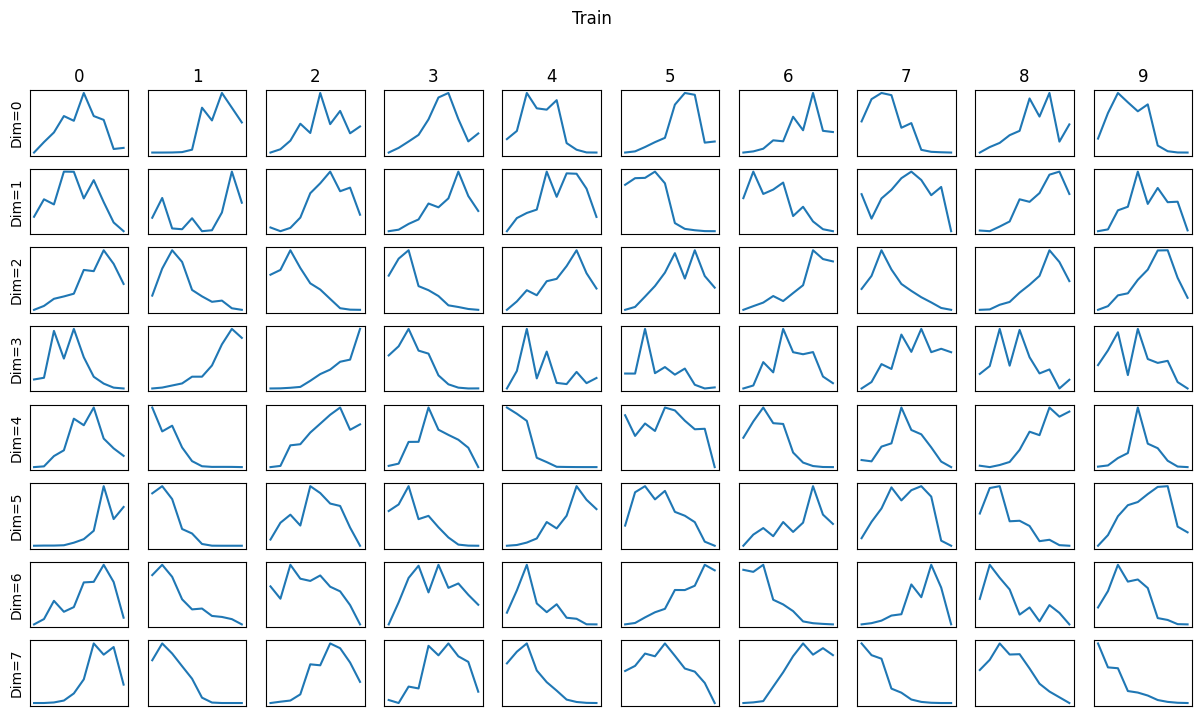

In [107]:
# check z distribution
dim = 0
ny = 10




dy_dim = 1

nx = 8*dy_dim
plt.figure(figsize=[15, nx])

for dim in range(8):
    for i in range(10):
        plt.subplot(nx, ny, (dim*dy_dim)*ny+ i+1)
        plt.plot(factors_probability1.detach().cpu()[targets==i].mean(0)[dim])
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        if dim == 0:
            plt.title(f"{i}")
        if i == 0:
            plt.ylabel(f"Dim={dim}")    
        
    # for i in range(10):
    #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
    #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
    #     plt.gca().set_yticks([])
    #     plt.gca().set_xticks([])
    #     # plt.title(f"{i}")
    
plt.suptitle(f"Train")




Text(0.5, 0.98, 'Test')

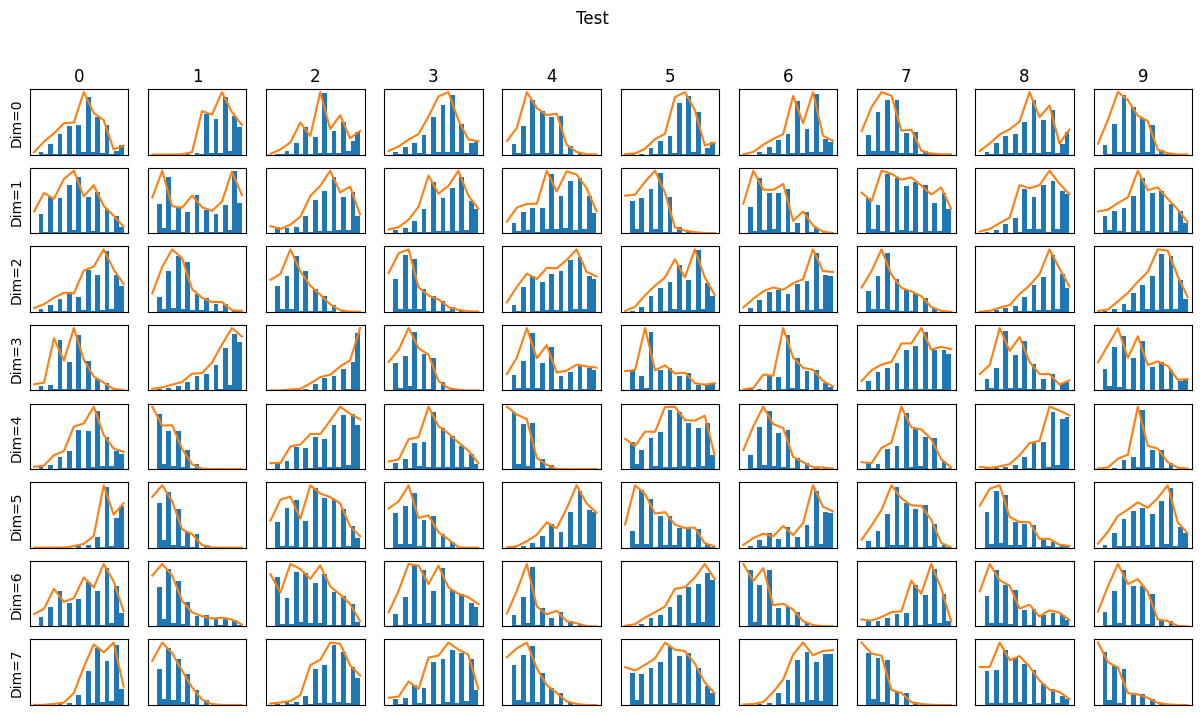

In [119]:
# check z distribution
dim = 0
ny = 10




dy_dim = 1

nx = 8*dy_dim
plt.figure(figsize=[15, nx])

for dim in range(8):
    for i in range(10):
        plt.subplot(nx, ny, (dim*dy_dim)*ny+ i+1)
        plt.hist(encoded_out_dim[:, dim].detach().cpu()[targets_test==i], bins=np.linspace(0, 1, 20), density=True)
        plt.plot(np.linspace(0, 1, 10), factors_probability.detach().cpu()[targets_test==i].mean(0)[dim]*20)
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        if dim == 0:
            plt.title(f"{i}")
        if i == 0:
            plt.ylabel(f"Dim={dim}")    
        
    # for i in range(10):
    #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
    #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
    #     plt.gca().set_yticks([])
    #     plt.gca().set_xticks([])
    #     # plt.title(f"{i}")
    
plt.suptitle(f"Test")

# for dim in range(8):
#     for i in range(10):
#         plt.subplot(nx, ny, i+1)
#         plt.hist(encoded_out_dim[:, dim].detach().cpu()[targets_test==i], bins=np.linspace(0, 1, 20), density=True, alpha=0.2)
#         plt.gca().set_yticks([])
#         plt.gca().set_xticks([])
#         if dim == 0:
#             plt.title(f"{i}")
#         if i == 0:
#             plt.ylabel(f"Dim={dim}")    
        
#     # for i in range(10):
#     #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
#     #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
#     #     plt.gca().set_yticks([])
#     #     plt.gca().set_xticks([])
#     #     # plt.title(f"{i}")
    
# plt.suptitle(f"Test")


In [47]:
encoded_out_dim[:, 0][targets_test==2].detach().cpu().unique().shape

torch.Size([453])

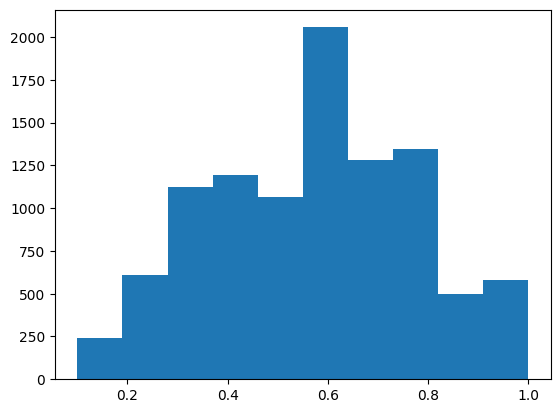

In [49]:
plt.hist(encoded_out_dim[:, 0].detach().cpu(), bins=10)
plt.show()